In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import timedelta

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4/'
save_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(save_path, "icu", "admissions.csv"))
lab = pd.read_csv(os.path.join(save_path, "hosp", "labevents.csv"), usecols=["subject_id", "hadm_id", "charttime", "valuenum", "label"])
inp = pd.read_csv(os.path.join(save_path, "icu", "inputevents.csv"), usecols=["subject_id", "hadm_id", "starttime", "amount", "label"])
out = pd.read_csv(os.path.join(save_path, "icu", "outputevents.csv"), usecols=["subject_id", "hadm_id", "charttime", "value", "label"])
pre = pd.read_csv(os.path.join(save_path, "hosp", "prescriptions.csv"), usecols=["subject_id", "hadm_id", "starttime", "dose_val_rx", "drug"])
# TODO[jacob]: `chartevents.csv` includes a stay_id, this should be incorporated when chart events is used
# cht = pd.read_csv(os.path.join(save_path, "icu", "chartevents.csv"))[["subject_id", "hadm_id", "stay_id", "charttime", "valuenum"]]

In [6]:
inp = inp.rename(columns={"starttime": "charttime", "amount": "valuenum"})
out = out.rename(columns={"value": "valuenum"})
pre = pre.rename(columns={"starttime": "charttime", "dose_val_rx": "valuenum", "drug": "label"})

inp["origin"] = "inputevents"
lab["origin"] = "labevents"
out["origin"] = "outputevents"
pre["origin"] = "prescriptions"
# cht["origin"] = "chartevents"

full = pd.concat([inp, lab, out, pre]).reset_index()
# full = pd.concat([inp, lab, out, pre, cht]).reset_index()

# Vancomycin is repeated in inputevents and labevents, so distinguish between them
full.loc[(full["label"]=="Vancomycin") & (full["origin"]=="labevents"), "label"] = "Vancomycin LAB"

# Check that all labels have different names.
assert(full["label"].nunique() == (inp["label"].nunique() + lab["label"].nunique() + out["label"].nunique() + pre["label"].nunique()))
# assert(full["label"].nunique() == (inp["label"].nunique() + lab["label"].nunique() + out["label"].nunique() + pre["label"].nunique() + cht["label"].nunique()))

del inp
del lab
del out
del pre
# del cht

print(full["label"].nunique())
full.head()

216


,index,subject_id,hadm_id,charttime,valuenum,label,origin
0,0,12422371,22216078.0,2137-08-19 08:00:00,240.0,PO Intake,inputevents
1,1,12422371,22216078.0,2137-08-20 07:59:00,100.0,PO Intake,inputevents
2,2,12422371,22216078.0,2137-08-19 18:00:00,480.0,PO Intake,inputevents
3,3,12422371,22216078.0,2137-08-20 12:17:00,300.0,PO Intake,inputevents
4,4,12422371,22216078.0,2137-08-20 09:00:00,350.0,PO Intake,inputevents


In [7]:
# Set the reference time as the lowest chart time for each admission.
full['charttime'] = pd.to_datetime(full["charttime"], format='%Y-%m-%d %H:%M:%S')
ref_time = full.groupby("hadm_id")["charttime"].min()

full = pd.merge(ref_time.to_frame(name="ref_time"), full, left_index=True, right_on="hadm_id")
full["timestamp"] = full["charttime"] - full["ref_time"]
assert(len(full.loc[full["timestamp"] < timedelta(hours=0)].index) == 0)

In [8]:
full.head()

,ref_time,index,subject_id,hadm_id,charttime,valuenum,label,origin,timestamp
16762,2128-09-14 17:00:00,16762,16058391,20000397.0,2128-09-18 05:12:00,20.000000,PO Intake,inputevents,3 days 12:12:00
16763,2128-09-14 17:00:00,16763,16058391,20000397.0,2128-09-17 23:07:00,180.000000,PO Intake,inputevents,3 days 06:07:00
16764,2128-09-14 17:00:00,16764,16058391,20000397.0,2128-09-17 18:44:00,120.000000,PO Intake,inputevents,3 days 01:44:00
364116,2128-09-14 17:00:00,364116,16058391,20000397.0,2128-09-17 17:08:00,123.000004,Dextrose 5%,inputevents,3 days 00:08:00
1121066,2128-09-14 17:00:00,1121066,16058391,20000397.0,2128-09-17 17:08:00,12299.999531,Heparin Sodium,inputevents,3 days 00:08:00


In [9]:
full["timestamp"].isna().sum()

0

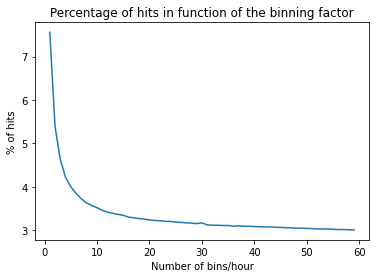

In [10]:
from tqdm import tqdm_notebook

# Plot the number of "hits" based on the binning. That is, the number of measurements falling into the same bin in function of the number of bins
bins_num = range(1, 60)
merged_df_short_binned = full.copy()
hits_vec = []
for bin_k in tqdm_notebook(bins_num):
    time_stamp_str = "TIME_STAMP_Bin_" + str(bin_k)
    merged_df_short_binned[time_stamp_str] = round(merged_df_short_binned["timestamp"].dt.total_seconds() * bin_k / 3600).astype(int)
    hits_prop = merged_df_short_binned.duplicated(subset=["hadm_id", "label", time_stamp_str]).sum() / len(merged_df_short_binned.index) * 100
    hits_vec += [hits_prop]
plt.plot(bins_num, hits_vec)
plt.title("Percentage of hits in function of the binning factor")
plt.xlabel("Number of bins/hour")
plt.ylabel("% of hits")
plt.show()

## Death tags

In [11]:
hosp_deaths = adm.groupby("hadm_id")["hospital_expire_flag"].unique().astype(int).to_frame().reset_index()
hosp_deaths = hosp_deaths.loc[hosp_deaths["hadm_id"].isin(full["hadm_id"])]
hosp_deaths.rename(columns={"hospital_expire_flag": "value"}, inplace=True)
hosp_deaths.to_csv(os.path.join(save_path, "processed", "hosp_deaths.csv"))

## ICD9 and ICD10

In [12]:
ICD_diag = pd.read_csv(os.path.join(file_path, "hosp", "diagnoses_icd.csv"))
ICD_diag

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9
...,...,...,...,...,...
4677919,13747041,25594844,10,N189,10
4677920,13747041,25594844,5,N179,10
4677921,13747041,25594844,6,R531,10
4677922,13747041,25594844,1,T50901A,10


In [13]:
# Main diagnoses
ICD_diag = ICD_diag.loc[(ICD_diag["seq_num"] == 1)]
ICD_diag

,subject_id,hadm_id,seq_num,icd_code,icd_version
3,11603789,25552978,1,65221,9
6,16809467,29803749,1,64511,9
13,11147319,25941345,1,65971,9
16,12156531,29321418,1,66411,9
22,14528388,29429446,1,65421,9
...,...,...,...,...,...
4677899,12225682,29240982,1,F419,10
4677902,15119129,28721266,1,T8132XA,10
4677905,19118815,29566765,1,M84422A,10
4677911,11735767,27197374,1,P599,10


In [14]:
full = pd.merge(full, ICD_diag[["hadm_id", "icd_code"]], on="hadm_id")

In [15]:
# Only select the first 3 digits of each ICD9 code.
full["icd_short"] = full["icd_code"].astype(str).str[:3]
# Check that all codes are 3 digits long.
str_len = full["icd_short"].str.len()
assert(str_len.loc[str_len!=3].count() == 0)

In [16]:
full["icd_short"].nunique()
# # Finer encoding (3 digits)
# hot_encodings = pd.get_dummies(complete_tensor["icd_short"])
# full[hot_encodings.columns] = hot_encodings

786

## Train-Validation-Test split

In [17]:
from sklearn.model_selection import train_test_split

# TODO[jacob]: consider stratification
def split_sets(df, test_size=0.1):
    df_1, df_2 = train_test_split(df, test_size=test_size)

    # Make sure that patients of the test set have instances in the training set. (same with labels but this should be nearly certain)
    assert(len(df_2.loc[~df_2["hadm_id"].isin(df_1["hadm_id"])].index) == 0)
    assert(len(df_2.loc[~df_2["label"].isin(df_1["label"])].index) == 0)

    return df_1, df_2

In [20]:
df_train, df_test = split_sets(full, test_size=0.1)

df_train_1, df_valid_1 = split_sets(df_train, test_size=0.2)
df_train_2, df_valid_2 = split_sets(df_train, test_size=0.2)
df_train_3, df_valid_3 = split_sets(df_train, test_size=0.2)
df_train_4, df_valid_4 = split_sets(df_train, test_size=0.2)
df_train_5, df_valid_5 = split_sets(df_train, test_size=0.2)

In [21]:
# Save
full.to_csv(os.path.join(save_path, "processed", "full.csv"))

df_train_1.to_csv(os.path.join(save_path, "processed", "folds", "df_train_1.csv"))
df_valid_1.to_csv(os.path.join(save_path, "processed", "folds", "df_valid_1.csv"))
df_train_2.to_csv(os.path.join(save_path, "processed", "folds", "df_train_2.csv"))
df_valid_2.to_csv(os.path.join(save_path, "processed", "folds", "df_valid_2.csv"))
df_train_3.to_csv(os.path.join(save_path, "processed", "folds", "df_train_3.csv"))
df_valid_3.to_csv(os.path.join(save_path, "processed", "folds", "df_valid_3.csv"))
df_train_4.to_csv(os.path.join(save_path, "processed", "folds", "df_train_4.csv"))
df_valid_4.to_csv(os.path.join(save_path, "processed", "folds", "df_valid_4.csv"))
df_train_5.to_csv(os.path.join(save_path, "processed", "folds", "df_train_5.csv"))
df_valid_5.to_csv(os.path.join(save_path, "processed", "folds", "df_valid_5.csv"))

df_train_1.to_csv(os.path.join(save_path, "processed", "df_test.csv"))